# Fit double components

In this notebook we will create a syntehtic SN3 spectrum with two Halpha components. We will then fit spectrum and plot the fit.


In [24]:
# Imports
import sys
sys.path.insert(0, '/home/carterrhea/Documents/LUCI/')  # Location of Luci
from LUCI.LuciSim import Spectrum
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from  scipy import interpolate
import LUCI.LuciFit as lfit
import LUCI.LuciPlotting as lplt
import keras

In [2]:
# Create first spectrum
lines = ['Halpha', 'NII6583', 'NII6548', 'SII6716', 'SII6731']
fit_function = 'sincgauss'
ampls = [2, 1, 0.3, 0.15, 0.25]  # Just randomly choosing these
velocity = 0  # km/s
broadening = 20  # km/s
filter_ = 'SN3'
resolution = 5000
snr = 50

spectrum_axis, spectrum = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

In [3]:
# Now create the second spectrum and add them together
lines = ['Halpha']
ampls = [1]  # Just randomly chosen
velocity = 200  # km/s

spectrum_axis2, spectrum2 = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

# Add them together
spectrum += spectrum2


In [4]:
# And we can now take a look

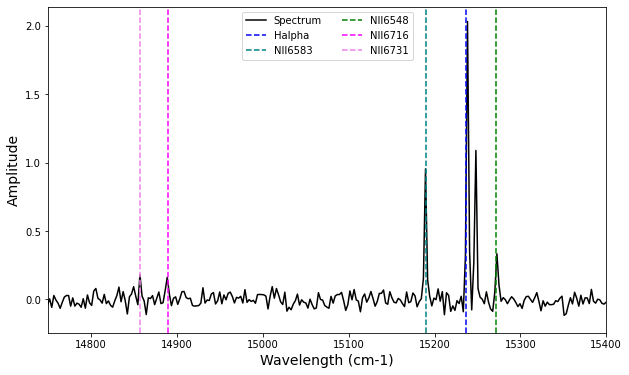

In [5]:
plt.figure(figsize=(10,6))
plt.plot(spectrum_axis, spectrum, color='black', label='Spectrum')
plt.xlim(14750, 15400)
plt.xlabel('Wavelength (cm-1)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.axvline(1e7/656.3, label='Halpha', color='blue', linestyle='--')
plt.axvline(1e7/658.3, label='NII6583', color='teal', linestyle='--')
plt.axvline(1e7/654.8, label='NII6548', color='green', linestyle='--')
plt.axvline(1e7/671.6, label='NII6716', color='magenta', linestyle='--')
plt.axvline(1e7/673.1, label='NII6731', color='violet', linestyle='--')
plt.legend(ncol=2)

plt.show()

We can clearly see that something is up with the Halpha line (because wd threw a second one there of course). Next, we can fit the components.

In [6]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('/home/carterrhea/Documents/LUCI/ML/Reference-Spectrum-R5000-SN3.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]
f = interpolate.interp1d(spectrum_axis, spectrum, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale


In [29]:
fit = lfit.Fit(spectrum.astype(np.double), spectrum_axis.astype(np.double), wavenumbers_syn, 'gaussian', 
               ['Halpha', 'Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], 
               [1,2,1,1,1,1], [1,2,1,1,1,1],
               #['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], 
               #[1,1,1,1,1], [1,1,1,1,1], 
               keras.models.load_model('/home/carterrhea/Documents/LUCI/ML/R5000-PREDICTOR-I-SN3'),
               bayes_bool=False, #, uncertainty_bool=True
               n_stoch=1
               )
fit_dict = fit.fit()


<AxesSubplot:xlabel='Wavelength [cm-1]', ylabel='Flux [ergs s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$]'>

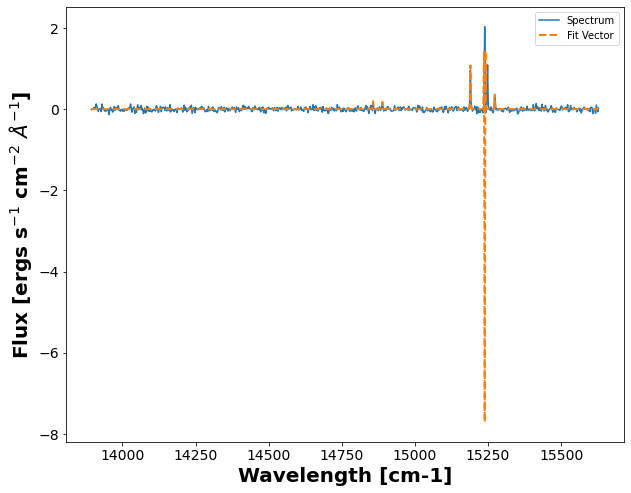

In [30]:
lplt.plot_fit(spectrum_axis, spectrum, fit_dict['fit_vector'])

In [11]:
fit_dict

{'fit_sol': array([ 3.81320585e+01,  1.52377401e+04,  1.03766229e+00, -4.58410408e+01,
         1.52375822e+04,  8.77549238e-01,  1.07931238e+00,  1.51900369e+04,
         1.03441379e+00,  3.57837343e-01,  1.52721110e+04,  1.04000288e+00,
         1.79761366e-01,  1.48891071e+04,  1.01392101e+00,  1.95121972e-01,
         1.48572975e+04,  1.01175484e+00,  6.97849817e-04]),
 'fit_uncertainties': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 'amplitudes': [38.13205846328002,
  -45.84104075990511,
  1.0793123766561517,
  0.35783734273927653,
  0.17976136564023731,
  0.19512197179970525],
 'fluxes': [50.82547028747653,
  -51.67269163576809,
  1.4340905680909484,
  0.47803018935851016,
  0.2341184308141778,
  0.2535809292236872],
 'flux_errors': [0.0, -0.0, 0.0, 0.0, 0.0, 0.0],
 'chi2': 9.244459701694746,
 'velocities': [-6.71768840249126,
  -3.6100942687936963,
  -6.717695021874337,
  -6.717693607917683,
  -6.717695506020849,
  -6.71769101672